In [1]:
import pandas as pd
import numpy as np
import yaml
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
from dag_gettsim.dag import compute_taxes_and_transfers

In [3]:
from gettsim.pre_processing.policy_for_date import get_policies_for_date

# The complete DAG

In [4]:
df = pd.read_csv("dag_gettsim/tests/test_dfs_ssc.csv")
raw_params = yaml.safe_load(
    Path("gettsim", "soz_vers_beitr.yaml").read_text(encoding="utf-8")
)

In [5]:
year_df = df.query("jahr == 2010")[[
    "bruttolohn_m",
    "wohnort_ost",
    "alter",
    "selbstständig",
    "hat_kinder",
    "eink_selbst_m",
    "ges_rente_m",
    "prv_krankv",
    "jahr"
]
]

In [6]:
params = get_policies_for_date(year=2010, group="soz_vers_beitr", raw_group_data=raw_params)

In [7]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=params, targets="sozialv_beitr_m", return_dag=True)

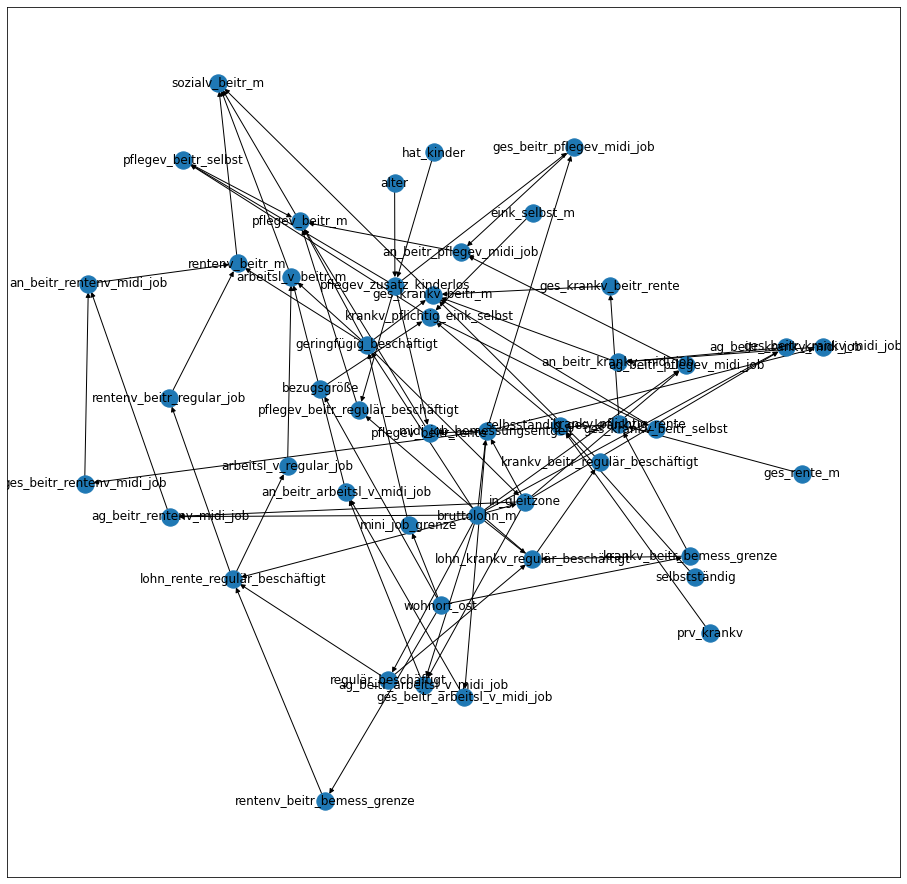

In [8]:
fig, ax = plt.subplots(figsize=(16, 16))
nx.draw_networkx(dag, ax=ax)

# Replace reform

In [9]:
# Increase bruttolohn to have a better example later
year_df.loc[:, "bruttolohn_m"] *= 100 

6     296.25
7     296.25
8     296.25
9     296.25
10    296.25
11    296.25
Name: krankv_beitr_regulär_beschäftigt, dtype: float64

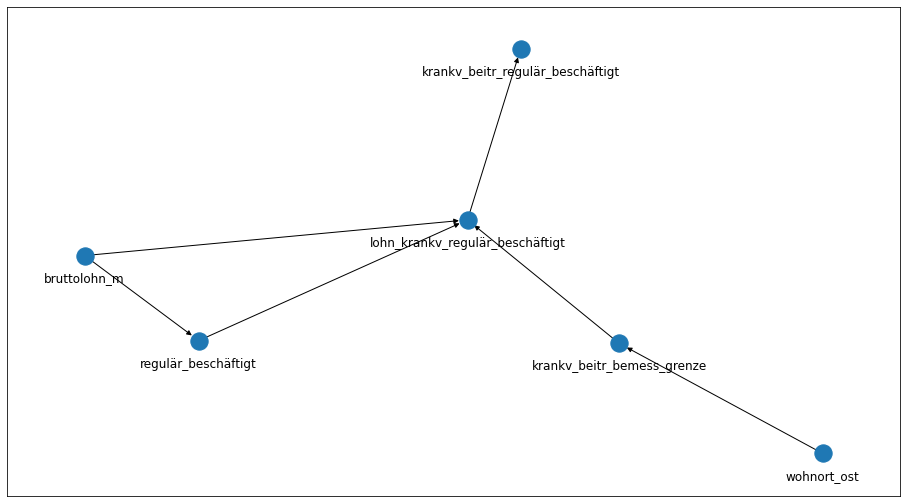

In [10]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=params, targets="krankv_beitr_regulär_beschäftigt", return_dag=True)
fig, ax = plt.subplots(figsize=(16, 9))
pos = nx.spring_layout(dag, seed=111)
nx.draw_networkx(dag, pos, ax=ax, with_labels=False)
pos = {key: pos[key] - [0, 0.1] for key in pos}
labels = nx.draw_networkx_labels(dag, pos, ax=ax)
data

In [12]:
def keine_beitr_bemessungsgrenze(wohnort_ost):
    return pd.Series(data=np.inf, index=wohnort_ost.index)

In [13]:
replace_func = {"krankv_beitr_bemess_grenze": keine_beitr_bemessungsgrenze}

6      2370.0
7      4740.0
8      7110.0
9      9480.0
10    11850.0
11    63200.0
Name: krankv_beitr_regulär_beschäftigt, dtype: float64

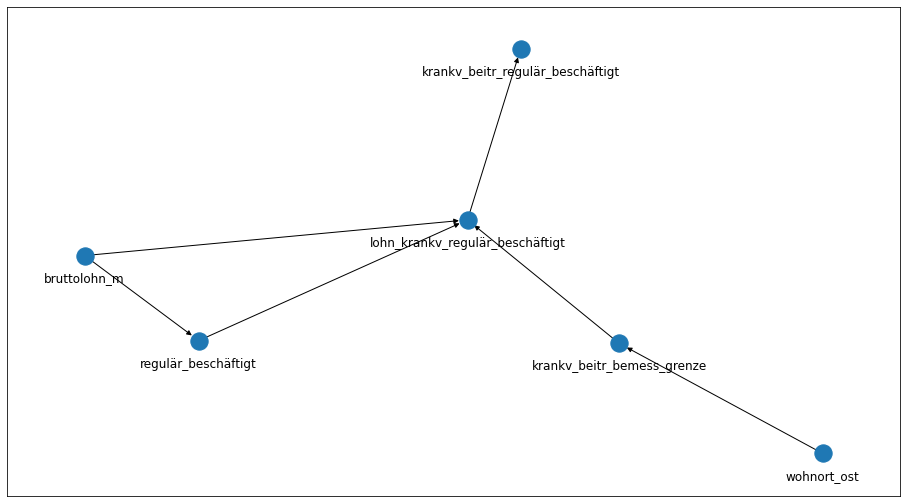

In [17]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=params, functions=replace_func, targets="krankv_beitr_regulär_beschäftigt", return_dag=True)
fig, ax = plt.subplots(figsize=(16, 9))
pos = nx.drawing.layout.spring_layout(dag, seed=111)
nx.draw_networkx(dag, pos, ax=ax, with_labels=False)
pos = {key: pos[key] - [0, 0.1] for key in pos}
labels = nx.draw_networkx_labels(dag, pos, ax=ax)
data

# Add a reform

In [18]:
def zusatz_steuer(bruttolohn_m, krankv_beitr_bemess_grenze, params):
    lohn_über_beitr_bemess_grenze = bruttolohn_m.loc[bruttolohn_m.gt(krankv_beitr_bemess_grenze)]
    out = lohn_über_beitr_bemess_grenze.multiply(params["soz_vers_beitr"]["ges_krankv"]["an"] / 2)
    return out.rename("zusatz_steuer")

In [19]:
def krankv_beitr_regulär_beschäftigt_mit_zusatz(lohn_krankv_regulär_beschäftigt, zusatz_steuer, params):
    """
    Calculates health insurance contributions for regualr jobs

    Parameters
    ----------
    lohn_krankv_regulär_beschäftigt : pd.Series
                                      Wage subject to health and care insurance
    params

    Returns
    -------
    Pandas Series containing monthly health insurance contributions for self employed
    income.
    """
    out = lohn_krankv_regulär_beschäftigt.multiply(params["soz_vers_beitr"]["ges_krankv"]["an"]) 
    out.loc[zusatz_steuer.index] += zusatz_steuer
    return out.rename("krankv_beitr_regulär_beschäftigt")

In [20]:
replace_func = {"zusatz_steuer": zusatz_steuer, "krankv_beitr_regulär_beschäftigt": krankv_beitr_regulär_beschäftigt_mit_zusatz}

6      1481.25
7      2666.25
8      3851.25
9      5036.25
10     6221.25
11    31896.25
Name: krankv_beitr_regulär_beschäftigt, dtype: float64

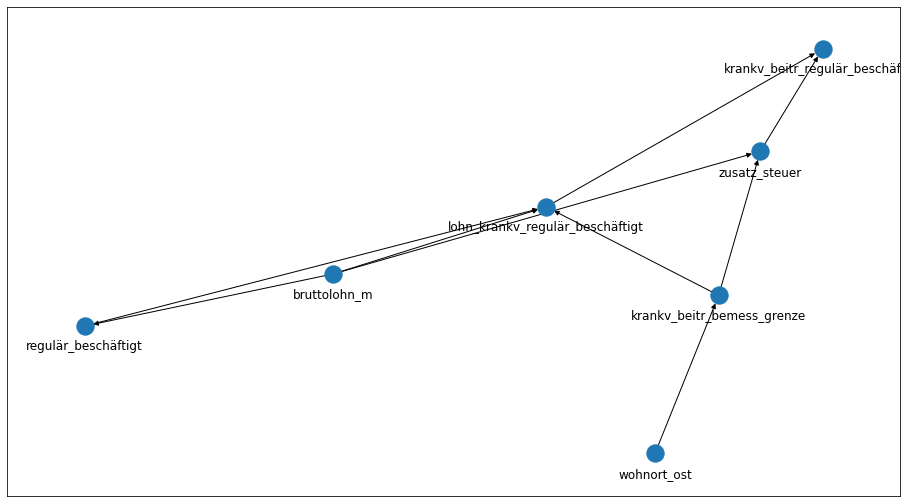

In [23]:
data, dag = compute_taxes_and_transfers(
    dict(year_df), params=params, functions=replace_func, targets="krankv_beitr_regulär_beschäftigt", return_dag=True)
fig, ax = plt.subplots(figsize=(16, 9))
pos = nx.drawing.layout.spring_layout(dag, seed=111)
nx.draw_networkx(dag, pos, ax=ax, with_labels=False)
pos = {key: pos[key] - [0, 0.1] for key in pos}
labels = nx.draw_networkx_labels(dag, pos, ax=ax)
data